# IN2110 obligatorisk innlevering 1a
**Våren 2023**

Det er en god idé å lese gjennom hele oppgavesettet før du setter i gang.
Dersom du har spørsmål så kan du:
- gå på gruppetime,
- spørre på  Discourse (https://in2110-discourse.uio.no/)
- eller sende epost til in2110-hjelp@ifi.uio.no dersom alternativene over av en eller annen grunn ikke passer for spørsmålet ditt.

## Oppsett
Når du har klonet dette github-repoet som denne notebooken ligger i, har du tilgang til datene og hjelpefilene som ligger i denne mappa. Hvis du ønsker å kopiere denne mappa, "1a", over til et annet sted, så skulle det gå bra. Bare pass på at du følger med på om det er oppdateringer her i repoet som gir ut obligen. Når du har aktivert in2110-miljøet med conda, så har du tilgang til pakkene som trengs for å kjøre denne notebooken.

## Bakgrunn
For denne innleveringen skal vi jobbe med datasettet Norwegian Review Corpus
(NoReC) som består av anmeldelser hentet fra en rekke norske nettaviser.
NoReC består av over 35.000 dokumenter fordelt på 9 tematiske kategorier. I dataene som er klargjort for oppgaven, er to av kategoriene fjernet for å spare plass. Vi skal kun se på 3 av de gjenstående kategoriene: ‘games’, ‘restaurants’ og ‘literature’. I oppgavene som følger skal vi skal jobbe med å *(i)* pre-prosessere tekstene, *(ii)* representere dem i en vektorrom-modell og så *(iii)* lage en klassifikator for å predikere hvilken kategori en gitt anmeldelse tilhører.

## Datagrunnlaget
Når vi jobber med klassifikasjon er det viktig at vi setter til side en del av
dokumentene slik at vi kan bruke disse til å evaluere klassifikatoren. NoReC er
delt i tre deler: ‘train’, ‘dev’ og ‘test’. Det er god praksis å trene med treningssettet
(‘train’), evaluere underveis med valideringssettet (‘dev’ for *development*)
og spare testsettet (‘test’) helt til slutt. Tekstene i NoReC er sortert på forhånd for å splittes i  ‘train’, ‘dev’ og ‘test’. Informasjonen om hvilken split dokumentet tilhører, ligger i metadata for hvert dokument. Slik dataene er lagret, er det en liste av dict- én for hvert dokument. Under nøkkelen "text" ligger teksten i dokumentet, og under nøkkelen "metadata" ligger en ny dict der vi kan finne kategorien til dokumentet, og hvilken split det tilhører. 


## Innleveringsformatet
Innleveringen skal helst bestå av én Jupyter notebook med både kode og tilhørende forklaringer. **La det siste du gjør før innlevering være å kjøre hele notebooken før du lagrer siste gang. Den skal kjøre uten å feile, og vise den grafikken og de utskriftene som skal være med.**
Vi understreker at innlevering av koden alene ikke er nok for å bestå oppgaven
– vi forventer at notebooken også skal inneholde beskrivelser (på norsk eller engelsk)
av hva dere har gjort og begrunnelser for valgene dere har tatt underveis. Bruk helst
hele setninger, og matematiske formler om nødvendig. La enhver oblig bli en trening i å formidle forskning. Evalueringstallene bør presenteres i tabeller. Det å forklare med egne ord (samt begreper vi har gått gjennom på
forelesningene) hva dere har implementert og reflektere over hvorvidt løsningen dere
har lagt besvarer oppgaven er en viktig del av læringsprosessen – ta det på alvor! 
Vi foretrekker som sagt at innleveringen deres kun består av én Jupyter notebook, men hvis
dere av tekniske grunner ikke klarer å besvare alle spørsmålene med Jupyter kan dere
også levere vanlige Python filer med en PDF-rapport som inneholder grafikken fra visualiseringen, og deres tekst-besvarelser.

### Tips for jobbing med notebooks
Det er en god idé å teste kode snarest mulig etter at du har lagd en ny funksjon. Lag deg gjerne ei ny celle i notebooken der du skriver ut et eksempel på dine data, og tester koden med eksempeldata som du lager deg. Slik testing er ikke en del av oppgaven, og kan slettes hvis den tar mye plass under kjøring. 

I prekoden står det `None` flere steder. Her skal din kode inn i stedet. I tillegg skal din kode inn de andre stedene der teksten sier det.

In [1]:
import json
import regex
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from helpers.oblig1 import scatter_plot, plot_confusion_matrix

# NLTK-ressurser vi skal ha tilgjengelig i denne obligen
resources = {"punkt": "tokenizers/punkt"}

for name, path in resources.items():
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)


## Oppgave 1 Data og pre-prosessering
### a) Data
Under er det en funksjon kalt prepare_data(). Denne tar inn en iterator
over dokumenter og skal returnere to lister: en liste med dokumenttekstene og
en liste med den respektive kategorien for hvert av dokumentene.
Skriv ferdig prepare_data(). Husk at vi kun ønsker dokumentene
i kategoriene ‘games’, ‘restaurants’ og ‘literature’.


In [2]:
def prepare_data(documents, split): # Oppgave 1 a
    """Tar inn en liste av dokumenter fra norec
    og returnerer to lister:

    - data   : En liste over dokument-tekstene.
    - labels : En liste over hvilken kategori dokumentet tilhører.

    Begge listene skal være like lange og for dokumentet i data[i]
    skal vi kunne finne kategorien i labels[i].

    Hvert element i listen documents er en dict der teksten ligger under nøkkelen "text", 
    og metadata ligger under nøkkelen "metadata".

    Dataene som sendes til funksjonen tilhører mange forskjellige kategorier. Vi skal bare ha disse tre: 'games','restaurants' og 'literature'.
    Parameteret "split" skal inneholde en av 'train', 'dev' eller 'test'. Bare dokumenter som har tilsvarende verdi i "split", skal returneres.
    """
    
    # Din kode her
    categories = ["games", "restaurants", "literature"]
    
    data = []
    labels = []
    
    for doc in documents:
        # Hvis dokumentet tilhører angitt split, og dokumentet tilhører én av kategoriene, inkludér dem
        if (doc["metadata"]["split"] == split) and (doc["metadata"]["category"] in categories):
            data.append(doc["text"])
            labels.append(doc["metadata"]["category"])

    assert len(data) == len(labels)
    return data, labels

In [3]:
# Tokeniseringsmetode: Angitte chars fjernes og hvert token får bare små bokstaver
def remove_chars_and_lower(text):
    chars = [".", "!", "'", '"', ":"] #Tegn uten spesiell mening i denne omgang
    tokenized = []
    tokens = text.split()
    for token in tokens:
        word = ""
        for char in token:
            if char not in chars:
                word += char
        tokenized.append(word.lower())
    return tokenized

In [4]:
# Tokeniseringsmetode: Bruker word_tokenize, fjerner angitte chars og hvert token får bare små bokstaver
def wordtokenize_remove_chars_and_lower(text):
    chars = [".", "!", "'", '"', ":"] #Tegn uten spesiell mening i denne omgang
    tokenized = []
    tokens = word_tokenize(text)
    for token in tokens:
       word = ""
       for char in token:
           if char not in chars:
               word += char
       tokenized.append(word.lower())
    return tokenized

In [5]:
def tokenize(text): #Oppgave 1 b
    """Tar inn en streng med tekst og returnerer en liste med tokens."""
    #tokenized = text.split()
    #tokenized = word_tokenize(text)
    #tokenized = remove_chars_and_lower(text)
    
    #Kommenterer ikke ut denne, siden metoden gir færrest ordtyper
    tokenized = wordtokenize_remove_chars_and_lower(text)
    
    return tokenized

word_tokenize splitter setningene i en tekst i tokens slik at spesialtegn (f.eks. kommaer) også behandles som tokens. Algoritmen medfører at ord som for eksempel slutter med komma, får kommaet fjernet. Dette til forskjell fra for eksempel text.split() uten argument.

In [6]:
# Prekode: Her laster vi inn dataene, etter at du har skrevet ferdig prepare_data()
datakilde = "norec_excerpts.json"
with open (datakilde, encoding = "utf-8") as rf:
    norecdata = json.load(rf)

# Treningsdata
train_data, train_labels = prepare_data(norecdata, "train")

# Valideringsdata
dev_data, dev_labels = prepare_data(norecdata, "dev")

# Testdata
test_data, test_labels = prepare_data(norecdata, "test")

Dokumentkorpuset deles inn i treningsdata, valideringsdata og testdata. Treningsdataene bruker jeg til å trene modellen. Valideringsdataene bruker jeg til å teste modellen underveis for å forbedre modellen. Testdataene brukes til å teste modellen helt til slutt. For å undersøke modellens evne til å generalisere til usette data, er det viktig med et testsett med dokumenter modellen aldri før har sett. Først med testsettet finner jeg ut den trente modellens evne til å kategorisere usette dokumenter.

## Oppgave 1
### b) Pre-prosessering
Prekoden over inneholder funksjonen tokenize() som splitter på mellomrom. Vi
ønsker en bedre tokenisering av dokumentene.
- Tokeniser treningssettet med den originale funksjonen og rapporter hvor mange tokens og hvor mange ordtyper du får.
- Endre funksjonen til å bruke en bedre tokenizer, f.eks. word_tokenize
i NLTK. Rapporter antall tokens og ordtyper for denne også.
- Prøv andre typer pre-prosessering, som f.eks. å gjøre om alle ord
til små bokstaver, normalisering av tall, eller normalisering av
tokens som betyr det samme (som f.eks. forskjellige typer hermetegn). 

Rapporter antall tokens og ordtyper for alle .
Hvilken tokenisering gir lavest antall ordtyper?

In [7]:
tokens = []
word_types = {}

# Tokeniserer hver tekst i treningssettet, og legger hvert token inn i tokens-lista
for text in train_data:
    tokenlist = tokenize(text)
    for token in tokenlist:
        tokens.append(token)
        
# Antall tokens totalt
print(len(tokens))

# Fyller ordboken med unike ord og antall per ordtype
for token in tokens:
    if token not in word_types:
        word_types[token] = 1
    else:
        word_types[token] += 1

# Antall ordtyper totalt
print(len(word_types))

2086952
115073


### Oppgave 1 b) Tekstbesvarelse

| Tokeniseringsmetode | Antall tokens | Antall ordtyper |
| ------------------- | ------------- | --------------- |
| text.split()        | 1829550 | 186519 |
| tegnfjerning og .lower() | 1829550 | 149968 |
| word_tokenize() | 2086952 | 127782 |
| tegnfjerning, fjerne tegn og .lower() | 2086952 | 115073

word_tokenizer brukt sammen med tegnfjerning og små bokstaver gir færrest antall ordtyper med 115073 ordtyper. Dette er forventet, siden word_tokenize behandler selv spesialtegn som tokens. Når enkelte spesialtegn fjernes sitter vi igjen med færre ordtyper.

## Oppgave 1 c) Statistikk
- Beregn antall dokumenter per kategori (‘games’, ‘restaurants’ og
‘literature’) i treningssettet.
- Diskuter kort fordelingen mellom kategoriene.

In [8]:
# Kode for å beregne antall dokumenter per kategori
doc_games = 0
doc_restaurants = 0
doc_literature = 0

for label in train_labels:
    if(label == "games"):
        doc_games += 1
    elif(label == "restaurants"):
        doc_restaurants += 1
    else:
        doc_literature += 1

print("Antall dokumenter i spillkategorien: " + str(doc_games))
print("Antall dokumenter i restaurantkategorien: " + str(doc_restaurants))
print("Antall dokumenter i litteraturkategorien: " + str(doc_literature))

Antall dokumenter i spillkategorien: 1413
Antall dokumenter i restaurantkategorien: 428
Antall dokumenter i litteraturkategorien: 2821


### Oppgave 1 c) Tekstbesvarelse
*Diskuter kort fordelingen mellom kategoriene:*  
Det er en skjevhet i antallet dokumenter på tvers av de tre kategoriene. Skjevheten kommer av et ulikt antall dokumenter tilhørende hver av de tre kategoriene. En slik skjevhet kan ha betydning for modellen og modellens generaliserbarhet (hvordan modellen kategoriserer dokumenter den ikke før har sett). Med andre ord vil en slik skjevhet kunne gjøre at modellens accuracy gir et feilaktig inntrykk av faktisk klassifikatorytelse.

# Oppgave 2 Dokumentrepresentasjon
Vi ønsker å representere dokumentene som vektorer, som vi så kan bruke som
input til å trene en klassifikator. Klassifikatoren lar oss predikere hvilken kategori et gitt
dokument tilhører. For å gjøre dette skal vi bruke scikit-learn. De klassene og
funksjonene dere trenger, er allerede importert i prekoden. Bruk gjerne litt tid
på å se på veiledningene på http://scikit-learn.org. I denne seksjonen skal
vi jobbe med å lese inn dokumentene og lage vektorrepresentasjoner. Så skal vi
jobbe med selve klassifikatoren i neste seksjon.

## Oppgave 2 a) Vektorisering
For å lage en tall-representasjon av dokumentene, skal vi bruke `CountVectorizer` fra scikit-learn for
å lage bag-of-words-representasjoner. Den tar inn en iterator
over dokumenter og returnerer en dokumentvektor for hvert dokument. Fordi
ordforrådet er så stort – over 500 000 ordtyper for hele NoReC – blir hver enkelt
dokumentvektor 500 000-dimensjonale hvis vi bruker alle ordene. Vi kommer til å
begrense oss til de 5000 mest frekvente ordene. Dette reduserer både minnebruk
og kjøretid.
CountVectorizer tar veldig mange argumenter, men dere kan ignorere de
fleste av dem; de eneste som er viktige for oss er lowercase, tokenizer og
max_features. Vi ønsker å bruke vår egen tokenizer, ikke den innebygde i
CountVectorizer, og vi ønsker heller ikke å la den gjøre om til lowercase –
vi kan heller gjøre om til små bokstaver i tokenize() om vi skulle ønske det.
Bruk argumentet max_features til å begrense ordforrådet. For å kunne ta i bruk
CountVectorizer må vi først identifisere ordtypene som skal inngå i ordforrådet / vokabularet til modellen. Det kan vi gjøre med metoden `fit()`. Det er
viktig at vi kun bruker trenings-settet for dette. Etter vi har identifisert vokabu-
læret kan vi anvende vektorisereren med `transform()`; dette vil altså opprette
dokumentvektorene. 

Endre prekoden under, slik at vi får: 
- instansiert en CountVectorizer med parametrene som beskrevet over
- trent vår vectorizert på våre treningsdata
- transformert både train, dev og test med vår trente vectorizer

In [9]:
# Vektorisering
vectorizer = CountVectorizer(lowercase=False, tokenizer=tokenize, max_features=5000)
vectorizer.fit(train_data) #Trener instansen på treningsdataene (lærer vokabularet med 5000 ord)
train_vec = vectorizer.transform(train_data) #Returnerer en dokument-termmatrise basert på 5000 ord
dev_vec = vectorizer.transform(dev_data) #Returnerer en dokument-termmatrise basert på 5000 ord
test_vec  = vectorizer.transform(test_data) #Returnerer en dokument-termmatrise basert på 5000 ord

/home/roberteg/anaconda3/envs/in2110/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Grunnen til at vi transformerer valideringsdataene og testdataene med samme vokabular som treningsdataene, er fordi vi fokuserer på modellens evne til å generalisere basert på et likt vokabular. Med andre ord vil vi sammenligne epler med epler fremfor epler og pærer. Dersom validerings- og testdataene har et annet vokabular enn treningsdataene, svekker det modellens generaliseringsevne og nøyaktighet. 

## Oppgave 2 b) Visualisering
*Hvis du har eksportert notebooken til .py og kjører uten grafisk grensesnitt, vil visualiseringen lagres som en PNG-fil.*

Nå har vi vektorisert dokumentene, men vi vet ikke om disse vektor-representasjonene
er gode eller ikke. For å få litt mer innsikt skal vi visualisere vektorene i treningssettet. Vi har laget en ferdig funksjon som dere kan bruke:
```
from helpers.oblig1 import scatter_plot
scatter_plot(vectors, labels)
```
Hvor `vectors` er de vektoriserte dokumentene og `labels` er listen over kategorien
til hvert av dokumentene. Visualiseringen viser en prikk for hvert dokument,
med farge avhengig av hvilken kategori det tilhører. Ideelt sett skulle vi sett at
hver kategori var en helt separat klynge, men i praksis er det alltid noe overlapp
mellom kategorier.

Visualiser dokumentvektorene for treningssettet. Beskriv og diskuter hva du ser.


/home/roberteg/IN2110/oblig_1a/helpers/oblig1.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, data=labels, cmap=cmap, label=label, alpha=0.5)


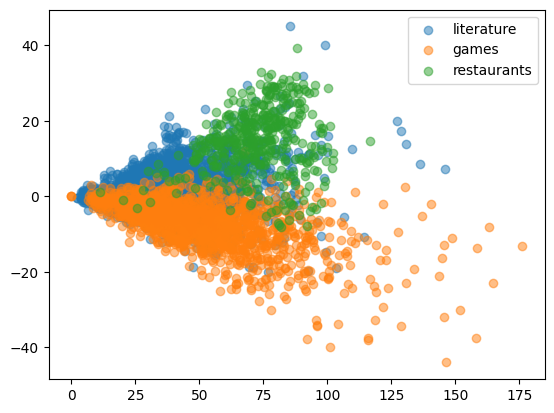

In [10]:
# Oppgave 2 b) Visualisering
scatter_plot(train_vec, train_labels)

### Oppgave 2 b) Tekstbesvarelse
*Beskriv og diskuter hva du ser i plottet.*  
Vi merker oss at scatter_plot-hjelpefunksjonen benytter dimensjonsreduksjon, hvilket medfører at det ikke kun er to features/to tokens som er representert ved aksene i vektorrommet. Informasjonen er snarere bevart med kun de to dimensjonene i vektorrommet som følge av dimensjonsreduksjonen.

Jeg ser områder med  mye overlapp mellom klassene games, restaurants og literature. Jeg ser også noen dokumenter som er lenger enn de andre (vektorene er lenger). De lengre dokumentene har trolig flere forekomster av enkelte ord enn hva de kortere dokumentene har, selv om de handler om det samme. Vi er ofte ute etter å klassifisere dokumenter etter kategorier (hva de handler om), snarere enn etter hvor hyppig spesifikke ord forekommer. Derfor blir det interessant å se om vekting med TF-IDF vil endre på inntrykket man får i plottet ovenfor. Ved TF-IDF-transformasjon legges det større vekt på tokens (ordtyper i dette tilfellet) som relativt sett forekommer oftere i enkelte dokumenter enn i resten av dokumentkorpuset. Min forventning er at TF-IDF-transformasjonen vil skape et noe tydeligere skille mellom dokumentklassene games, literature og restaurants.

## Opppgave 2 c) Vekting
For å få bedre representasjoner kan det være lurt å vekte trekkene i ordvektorene,
slik at de trekkene som er mer informative gis høyere vekt. Vi skal se på en type
vekting kalt *term frequency–inverse document frequency (tf-idf)*. Scikit-learn
har en innebygd klasse for tf-idf kalt `TfidfTransformer` som vi skal bruke.
Den tar dokumentvektorer som input og gir ut nye vektorer som output. I
likhet med CountVectorizer må denne tilpasses treningssettet med fit() eller
fit_transform() før vi kan ta den i bruk (fordi vi først må gjøre de nødvendige
frekvenstellingene i korpuset).
- Lag en tf-idf-vektet representasjon av dokumentene
- Visualiser treningsvektorene som er vektet med tf-idf. Ser du
noen forskjell mellom vektorene med og uten tf-idf?

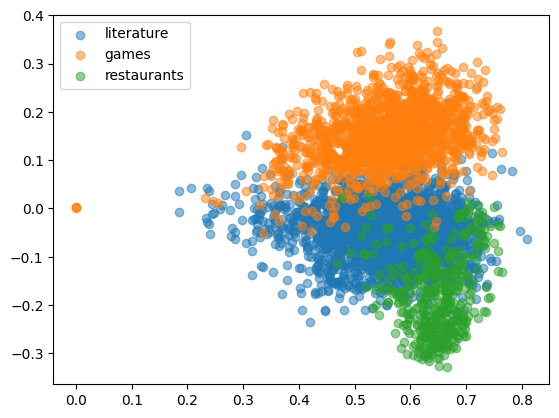

In [11]:
## Opppgave 2 c) Vekting, din kode:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(train_vec) #Trener instansen på våre treningsdata
train_vec_tfidf = tfidf_transformer.transform(train_vec) #Treningsdata tf-idf-transformert
dev_vec_tfidf = tfidf_transformer.transform(dev_vec) #Valideringsdata tf-idf-transformert
test_vec_tfidf = tfidf_transformer.transform(test_vec) #Testdata tf-idf-transformert

# Din kode for å visualisere tf-idf-transformerte treningsdata:
scatter_plot(train_vec_tfidf, train_labels)

### Oppgave 2 c) Tekstbesvarelse
Jeg observerer mindre overlapp mellom klassene etter at dokumentvektorene er TF-IDF-transformerte. Samtidig er det færre uteliggere etter transformasjonen.    

Ord med høyere TF-IDF-frekvens brukes til å skille dokumenter fra hverandre, siden ord som forekommer relativt oftere på tvers av dokumentene tillegges mindre vekt. Følgelig legges det mer vekt på ord som forekommer relativt sjeldnere i dokumentkorpuset. Selv om det ofte er et skille mellom games-, literature-, og restaurants-dokumentene, finnes det dokumenter som er like på tvers av klassene. Der hvor det er tydeligere forskjeller mellom dokumentene, er de TF-IDF-transformerte dokumentvektorene forskjellige - altså har dokumentene flere unike ord som skiller dem fra resten. Ellers er det enklere å se at restaurant-klassen innehar færrest dokumenter av de tre klassene.  

Siden det er overlapp mellom klassene, er ikke klassene lineært separerbare. Det blir derfor viktig å velge en ikke-lineær klassifikator, som kNN (k Nearest Neighbours), fremfor Rocchio. Rocchio er en lineær klassifikator som forutsetter lineær separerbarhet mellom klassene, og vil egne seg dårlig her.

# Oppgave 3: Klassifisering
Vi skal bruke k-NN for å predikere hvilken kategori dokumentene i valideringssettet og testsettet tilhører ved hjelp av `KNeighborsClassifier` fra scikit-learn.
Klassifikatoren trenes med fit() på treningsdataene og kan brukes for å predikere med predict() på testdata. For best resultat er det viktig at trenings- og
testdataene er pre-prosessert på samme måte. F.eks. vil en klassifikator trent
uten tf-idf gi dårlige resultater for dokumentvektorer med tf-idf. 
#### Hyper-parameter tuning
Ved å endre på verdien av k kan man tilpasse klassifikatoren. Avhengig av datasett, preprosessering og vekting vil forskjellige verdier av k kunne gi forskjeller i ytelse. *K* er en hyperparameter i dette maskinlæringsprosjektet, og vi skal øve på å finne beste hyperparameter, ved å prøve en rekke alternativer for å se hva som gir best resultat. Det er her dev-settet kommer inn som et midlertidig testsett mens vi utvikler beste modell. Siden vi definerer "beste modell" som den som gjør det best på dev-settet, er det viktig at vi sparer det endelige testsettet til slutt, slik at vi ser hvordan modellen fungerer på data som vi ikke har brukt på noe trinn i utviklingen av modellen.

### a) k-NN
Lag en instans av KNeighborsClassifier der k = 3. Tren denne på treningsdata, og test på dev-data ved hjelp av accuracy_score

### b) Evaluering
Et vanlig brukt mål får å evaluere en klassifikator er accuracy. Vi kan beregne
dette ved hjelp av funksjonen `accuracy_score()` fra scikit-learn. Den tar to
argumenter: en liste med sanne merkelapper og en med predikerte merkelapper.
De sanne merkelappene er listen over kategorier for hvert dokument som vi
fikk fra NoReC (altså såkalte ‘gull-standard’ merkelapper), mens de predikerte
er modellens egne som vi får fra predict(). 

**Hyper-parameter tuning:** 
Lag ei sløyfe som trener en klassifikator for forskjellige verdier av k med og uten tf-idf, 
og beregn accuracy for hver av dem. Du kan f.eks. teste med k fra 1 til 20. 
- Inkluder en tabell med resultatene i rapporten.
- Diskuter resultatene dine. Hvilken kombinasjon av vekting og k-
verdi gir best accuracy?

In [12]:
# Oppgave 3 a) Din koding:

# Lag en instans av KNeighborsClassifier der k = 3:
knn_clf = KNeighborsClassifier(3)

# Tren denne på treningsdata:
knn_clf.fit(train_vec_tfidf, train_labels)

# Test klassifikatoren ved hjelp av accuracy_score():
pred_dev = knn_clf.predict(dev_vec_tfidf)
pred_dev_acc = accuracy_score(y_true=dev_labels, y_pred=pred_dev)
print("Accuracy: " + "%.3f" % pred_dev_acc)

Accuracy: 0.978


kNN-klassifikatoren til scikit-learn bruker Euklidsk avstand (Euclidean distance) som standard mål på avstand mellom dokumentvektorene. Siden dokumentvektorene er TF-IDF-transformerte, vil Euklidsk avstand gi samme konklusjon som cosinuslikhet (cosinus av vinklene mellom dokumentvektorene). Med TF-IDF-transformasjon slipper vi å normalisere dokumentvektorene til lengde lik 1, fordi vi bruker vektede relative frekvenser fremfor absolutte antall av hvert token i dokumentvektorene.  

Viktig å merke seg med k = 3: k tilsvarer her antall nærmeste naboer, ikke antallet klasser. Klassifikatoren over ser på de tre nærmeste naboene til et dokument når modellen trenes og seinere brukes til klassifisering av nye dokumenter. Majoritetsklassen til de k nærmeste naboene angir klassen/kategorien til nye objekter i en kNN-klassifikator.

In [13]:
# Oppgave 3 b) Din koding:
"""Lag ei sløyfe som trener en klassifikator for forskjellige verdier av k med og uten tf-
idf, og beregn accuracy for hver av dem:"""

acc_tfidf_scores = []
acc_scores = []

for k in range(20):
    # Trening på TF-IDF-transformerte data
    knn_clf_tuning = KNeighborsClassifier(k+1)
    knn_clf_tuning.fit(train_vec_tfidf, train_labels)
    pred_dev_tuning = knn_clf_tuning.predict(dev_vec_tfidf)
    pred_dev_tuning_acc_tfidf = accuracy_score(y_true=dev_labels, y_pred=pred_dev_tuning)
    acc_tfidf_scores.append(pred_dev_tuning_acc_tfidf)
    
    # Trening uten TF-IDF-transformerte data
    knn_clf_tuning = KNeighborsClassifier(k+1)
    knn_clf_tuning.fit(train_vec, train_labels)
    pred_dev_tuning = knn_clf_tuning.predict(dev_vec)
    pred_dev_tuning_acc = accuracy_score(y_true=dev_labels, y_pred=pred_dev_tuning)
    acc_scores.append(pred_dev_tuning_acc)

In [14]:
#Skriver ut accuracy scores for modellen uten og med TF-IDF-transformasjon
for k in range(20):
    acc = "%.3f" % acc_scores[k]
    acc_tfidf = "%.3f" % acc_tfidf_scores[k]
    print(str(k+1) + " " + acc_tfidf + " " + acc)

1 0.899 0.881
2 0.851 0.878
3 0.978 0.876
4 0.981 0.888
5 0.985 0.881
6 0.983 0.893
7 0.986 0.883
8 0.986 0.892
9 0.986 0.883
10 0.986 0.890
11 0.986 0.881
12 0.986 0.883
13 0.988 0.878
14 0.988 0.888
15 0.990 0.871
16 0.986 0.875
17 0.986 0.866
18 0.981 0.875
19 0.974 0.859
20 0.978 0.857


### Oppgave 3b Tekstbesvarelse
k = 15 med TF-IDF-vekting gir høyest accuracy (nøyaktighet). Det vil si at et valideringsdokumentets klasse defineres ut ifra majoritetsklassen til dokumentets femten nærmeste naboer. Når k er lik 15 er nøyaktigheten på 0.99 (99 %). Det vil si at klassifikatoren har klart å angi riktig kategori for 99 % av dokumentene i valideringssettet. For 1 % av dokumentene har klassifikatoren angitt feil kategori; det vil si at klassifikatoren har kategorisert dokumenter til å handle om games, restaurants eller literature når dokumentene egentlig tilhører en av de to andre kategoriene. Frem til k = 15 konvergerer accuracy mot 0.99, deretter går accuracy ned igjen. Sistnevnte tyder på at modellen blir preget av lavere varians og høyere bias (undertilpasning) når k > 15.

Verdt å merke seg er at nøyaktigheten jevnt over er lavere uten TF-IDF-vekting. Dermed er det klart at ordvektinger, som tydelig skiller dokumenter fra andre dokumenter i dokumentkorpuset, er av betydelighet for klassifikatorens accuracynøyaktighet.

|k|Accuracy_TF-IDF|Accuracy|
|--|-----|-----|
|01| 0.899 | 0.881 |
|02| 0.851 | 0.878 |
|03| 0.978 | 0.876 |
|04| 0.981 | 0.888 | 
|05| 0.985 | 0.881 |
|06| 0.983 | 0.893 |
|07| 0.986 | 0.883 |
|08| 0.986 | 0.892 |
|09| 0.986 | 0.883 |
|10| 0.986 | 0.890 |
|11| 0.986 | 0.881 |
|12| 0.986 | 0.883 |
|13| 0.988 | 0.878 |
|14| 0.988 | 0.888 |
|15| 0.990 | 0.871 |
|16| 0.986 | 0.875 |
|17| 0.986 | 0.866 |
|18| 0.981 | 0.875 |
|19| 0.974 | 0.859 |
|20| 0.978 | 0.857 |

## Oppgave 3 c) Testing
Vi har tilpasset parameterene til klassifikatoren vår til valideringssettet og nå
ønsker vi å gjøre en siste evaluering på testsettet. For å få mest mulig realistiske
og representative resultater er det viktig at vi venter med dette helt til slutt,
slik at vi ikke tilpasser klassifikatoren testsettet. Fordi vi vil teste hvor bra
klassifikatoren vår kan generalisere til nye data, må vi være nøye på at det
reserverte testsettet er nettopp dette – nye data som ikke har påvirket de valgene
vi har tatt for klassifikatoren vår.

- Tren en klassifikator med samme valg for k-verdi og vekting (tf-idf
eller ikke) som den med høyest accuracy i forrige deloppgave.
- Test på tilsvarende representasjon av test-settet
- Hvordan er ytelsen på testsettet sammenlignet med valideringssettet?

In [15]:
# Din kode for trening av modell med beste parametre, og teste på test-settet
knn = KNeighborsClassifier(15) #Oppretter en kNN-klassifikator med k = 15
knn.fit(train_vec_tfidf, train_labels) #Trener 15NN-modellen på treningsdataene
knn_test_pred = knn.predict(test_vec_tfidf) #Predikerer dokumentkategorier for testdataene

In [16]:
#Beregner og skriver ut accuracy for testdataene
knn_test_acc = accuracy_score(y_true=test_labels, y_pred=knn_test_pred) 
print("Modellens accuracy for testdataene: " + ("%.3f" % knn_test_acc))

#Beregner og skriver ut F-score for testdataene (fordi det er en ubalanse i dokumentantallet på tvers av klassene). 
# average = "weighted" for å ihensynta ulikt dokumentantall innen de ulike kategoriene
knn_test_fbeta = f1_score(y_true=test_labels, y_pred=knn_test_pred, average="weighted") 
print("Modellens F-score for testdataene: " + ("%.3f" % knn_test_fbeta))

Modellens accuracy for testdataene: 0.981
Modellens F-score for testdataene: 0.981


### Oppgave 3c Tekstbesvarelse
*Hvordan er ytelsen på testsettet sammenlignet med valideringssettet?*  

Ytelsen er bittelitt bedre på valideringssettet sammenlignet med testsettet, tilsvarende 0.9 prosentpoeng (accuracy testsett = 0.981 og accuracy valideringssett = 0.990). Altså er det god balanse mellom varians og bias med k = 15. Modellen er hverken overtilpasset eller undertilpasset treningsdataene. Hadde k = 1, ville modellen hatt høyere varians og lavere bias. Hvis k = N (N = antall dokumenter i korpuset), ville modellen hatt lavere varians og høyere bias i favør av majoritetsklassen. Jeg vet fra før av at det er en ubalanse mellom klassene, bl.a. med flere tilfeller av både games og literature enn restaurants. Derfor ville jeg sjekke F-score i tillegg til accuracy. Siden både accuracy og F-score er høye og identiske, har ikke ubalansen mellom klassene påvirket modellens ytelse. Konklusjonen er at modellen generaliserer til usette data (her: testdata), som er målet i maskinlæring (her: dokumentklassifikasjon).